In [11]:
import sqlite3
import pandas as pd
import numpy as np
import os
import polars as pl

import random
random.seed(42)

import sys

sys.path.append('../')
sys.path.append('../networks')
from dotenv import load_dotenv

import plotly.express as px

In [12]:
# Load the environment variables from the .env file
dotenv_path = os.path.join('../', '.env')
load_dotenv(dotenv_path)

True

In [13]:
from functions.env import DB_SCIENCE_PATH

conn = sqlite3.connect(DB_SCIENCE_PATH)
conn_full_db = sqlite3.connect(os.getenv("FULL_DB_PATH"))

columns_to_keep = [
        "re_arabic_world",
        "re_central_europe",
        "re_chinese_world",
        "re_eastern_europe",
        "re_france",
        "re_german_world",
        "re_greek_world",
        "re_indian_world",
        "re_italy",
        "re_japan",
        "re_low_countries",
        "re_nordic_countries",
        "re_persian_world",
        "re_slav_world",
        "re_spain",
        "re_united_kingdom",
    ]


df_occupation = pd.read_sql("SELECT * FROM individual_id_cleaned_occupations", conn)


df_ind_regions = pd.read_sql_query(
        "SELECT * FROM individuals_regions", conn_full_db
    )
df_ind_regions = df_ind_regions.rename(
        columns={"individual_wikidata_id": "wikidata_id"}
    )


list_non_specialist = df_occupation.groupby('wikidata_id')['meta_occupation'].count().reset_index()
list_non_specialist = list_non_specialist[list_non_specialist['meta_occupation']>1]
list_non_specialist =list(list_non_specialist['wikidata_id'])


df_indi = pd.merge(df_occupation, df_ind_regions, on = 'wikidata_id', how = 'left')
df_indi = df_indi[['wikidata_id', 'region_code', 'region_name']].drop_duplicates()

# remove the non specialist
df_indi = df_indi[~df_indi['wikidata_id'].isin(list_non_specialist)]
df_indi = df_indi[df_indi['region_code'].isin(columns_to_keep)]

In [14]:
df_indi_non_specialist = pd.merge(df_occupation, df_ind_regions, on = 'wikidata_id', how = 'left')
df_indi_non_specialist = df_indi_non_specialist[['wikidata_id', 'region_code', 'region_name']].drop_duplicates()
df_indi_non_specialist = df_indi_non_specialist[df_indi_non_specialist['region_code'].isin(columns_to_keep)]
df_indi_non_specialist = df_indi_non_specialist[df_indi_non_specialist['wikidata_id'].isin(list_non_specialist)]

In [15]:
import matplotlib.pyplot as plt

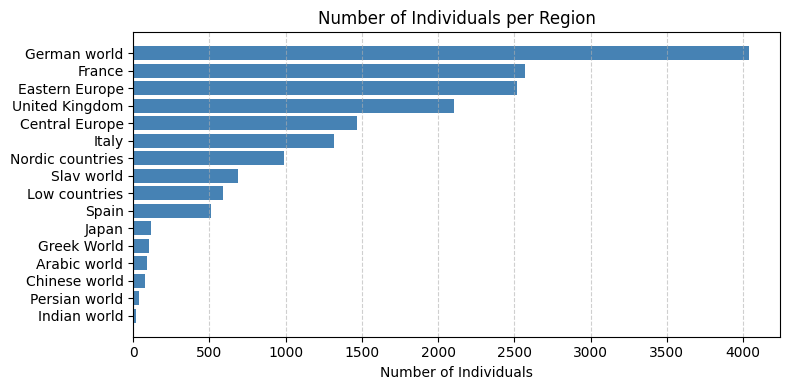

In [16]:

region_counts = df_indi['region_name'].value_counts()
categories = list(reversed(list(region_counts.index)))
values = list(reversed(list(region_counts.values)))

region_counts_specialists = df_indi_non_specialist['region_name'].value_counts()
categories_specialist = list(reversed(list(region_counts_specialists.index)))
values_specialist = list(reversed(list(region_counts_specialists.values)))


# Choose a suitable color for a scientific paper
bar_color = '#4682B4'  # Steel Blue

# Create a horizontal bar plot
plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
plt.barh(categories, values, color=bar_color)

# Add labels and title
plt.xlabel('Number of Individuals')
plt.ylabel('')
plt.title('Number of Individuals per Region')

# Show the plot
plt.grid(axis='x', linestyle='--', alpha=0.6)  # Add horizontal grid lines
plt.tight_layout()  # Ensure labels fit within the figure
plt.show()

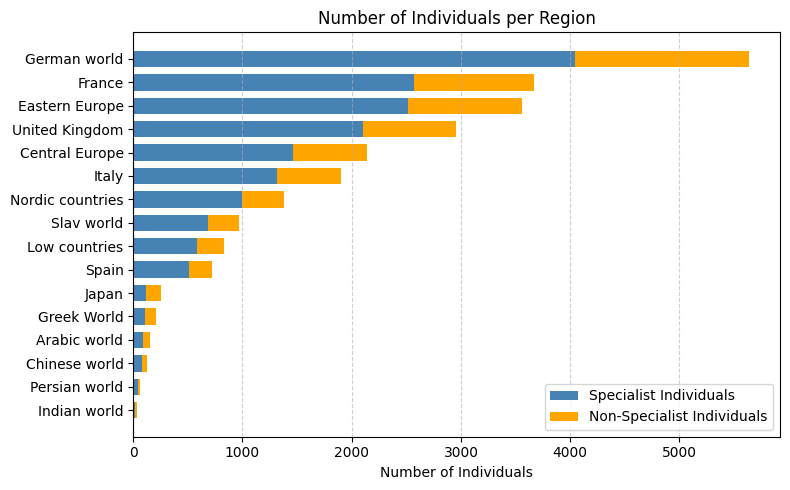

In [17]:
# Choose colors for the bars
bar_color = '#4682B4'  # Steel Blue
bar_color_specialist = '#FFA500'  # Orange (you can choose another color)

# Set the width of the bars
bar_width = 0.7

# Calculate the positions for the bars
x = np.arange(len(categories))

# Create the figure and axis
plt.figure(figsize=(8, 5))  # Adjust the figure size as needed
plt.barh(x, values, bar_width, color=bar_color, label='Specialist Individuals')
plt.barh(x, values_specialist, bar_width, left=values, color=bar_color_specialist, label='Non-Specialist Individuals')

# Add labels and title
plt.xlabel('Number of Individuals')
plt.ylabel('')
plt.title('Number of Individuals per Region')

# Set the y-axis ticks and labels to be the region names
plt.yticks(x, categories)

# Add a legend
plt.legend(loc='lower right')

# Show the plot
plt.grid(axis='x', linestyle='--', alpha=0.6)  # Add horizontal grid lines

# Show the plot
plt.tight_layout()
plt.show()

### Create the table

In [18]:
df_region_counts_specialists = region_counts_specialists.reset_index()
df_region_counts_specialists.columns = ['region_name', 'count_non_specialists']

df_region_counts = region_counts.reset_index()
df_region_counts.columns = ['region_name', 'count_specialists']

df_table = pd.merge(df_region_counts_specialists, df_region_counts, on = 'region_name')
df_table['total'] = df_table['count_non_specialists'] + df_table['count_specialists']
df_table = df_table.sort_values('total', ascending=False)

df_table.to_clipboard(index=False)

In [19]:
df_ind_score = pd.read_sql("SELECT * FROM individual_score", conn)
df_ind_region = pd.read_sql("SELECT * FROM temporal_data", conn)
df_ind_region = df_ind_region[['wikidata_id', 'region_code']].drop_duplicates()
df_ind_region = df_ind_region[df_ind_region['region_code'].isin(columns_to_keep)]

df_regions_name = pd.read_sql_query(
        "SELECT * FROM regions", conn_full_db
    )
df_ind_region = pd.merge(df_ind_region, df_regions_name, on = 'region_code')
df_ind_region = df_ind_region.drop('region_code', axis=1)
df_ind_region = df_ind_region.rename(columns = {'region_name':'region_code'})

df_fame = pd.merge(df_ind_score, df_ind_region, on = 'wikidata_id')
df_fame = df_fame.sort_values(['region_code', 'score'], ascending= (False, False))
df_fame = df_fame.groupby('region_code').head(3).reset_index(drop=True)

df_main_information = pd.read_sql_query(
        "SELECT * FROM individuals_main_information", conn_full_db
    )

df_main_information = df_main_information[['individual_wikidata_id', 'individual_name']]
df_main_information = df_main_information.rename(columns = {'individual_wikidata_id':'wikidata_id'})

df_fame = pd.merge(df_main_information, df_fame, on = 'wikidata_id')
df_fame = df_fame.groupby('region_code')['individual_name'].apply(lambda x : ' | '.join(x))
df_fame = df_fame.reset_index()
df_fame = df_fame.rename(columns = {'region_code':'region_name'})

df_table_names = pd.merge(df_table, df_fame, on = 'region_name')
df_table_names.to_clipboard(index=False)

df_table_names

,region_name,count_non_specialists,count_specialists,total,individual_name
0,German world,1597,4041,5638,Johann Sebastian Bach | Johann Wolfgang von Go...
1,France,1102,2568,3670,Voltaire | Jules Verne | René Descartes
2,Eastern Europe,1047,2516,3563,Antonín Dvořák | Pyotr Ilyich Tchaikovsky | Le...
3,United Kingdom,854,2104,2958,Lewis Carroll | Charles Darwin | Isaac Newton
4,Central Europe,588,1465,2053,Antonín Dvořák | John Amos Comenius | Nicolaus...
5,Italy,671,1317,1988,Galileo Galilei | Dante Alighieri | Leonardo d...
6,Nordic countries,386,992,1378,Tycho Brahe | Carl Linnaeus | Emmanuel Swedenborg
7,Slav world,277,689,966,Nikolai Rimsky-Korsakov | Pyotr Ilyich Tchaiko...
8,Low countries,248,586,834,Gerardus Mercator | Christiaan Huygens | Bened...
9,Spain,211,513,724,Bartolomé de Las Casas | Alfonso X of Castile ...
